In [1]:
from spectral import *
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from lazypredict.Supervised import LazyClassifier
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from collections import Counter
from scipy.stats import reciprocal
from sklearn.metrics import accuracy_score
from skopt.space import Real, Categorical, Integer
from skopt.plots import plot_objective, plot_histogram, plot_evaluations
import pandas as pd
import skopt
from sklearn.model_selection import train_test_split
import tqdm
print(f'numpy Version: {np. __version__}')

# set parameters
sns.set(style="white")
plt.set_cmap('jet')

numpy Version: 1.24.3


<Figure size 640x480 with 0 Axes>

# Load the UPWINS spectral library and metadata csv

In [2]:
# Read the spectral library using the spectral package
lib = envi.open('data/UPWINS_spectral_library_6_25_2024.hdr')
print(f'Number of spectra in libary: {len(lib.names)}')
print(f'Number of bands in library: {len(lib.bands.centers)}')

# remove spectra with large derivate, which are the spectra collected using sunlight
derivitive = np.mean(np.abs(lib.spectra[:,1:]-lib.spectra[:,:-1]), axis=1)
select_indices = np.where(derivitive<0.0025)[0]
# create variables for the library data 
names = np.asarray(lib.names)[select_indices]
spectra = lib.spectra[select_indices,:]
wl = np.asarray(lib.bands.centers)
# create variables for the library metadata 
nSpec = len(names)
nBands = len(wl)

print(' ')
print('...remove spectra collected using outdoor solar illumination...')
print(' ')
print(f'Number of spectra: {nSpec}')
print(f'Number of bands: {nBands}')

Number of spectra in libary: 1069
Number of bands in library: 2151
 
...remove spectra collected using outdoor solar illumination...
 
Number of spectra: 917
Number of bands: 2151


In [3]:
# read the metadata dataframe and extract the metadata as numpy arrays
df = pd.read_csv('data/UPWINS_spectra_metadata_6_25_2024.csv', keep_default_na=False)
genus = []
species = []
principle_part = []
health = []
growth_stage = []
DateTimeId = []
month = []
plant_type = []
name = []
name_full_category = []
name_genus_species = []
select_indices = []
for i in range(len(names)):
    row = df.loc[df['ASD UPWINS base_fname'] == names[i]+'.asd']
    # if the spectrum has a corresponding row in the csv
    if (row['sub-category'].values[0] not in ['NA','backrounds']) & (row['category'].values[0] in ['vegetation','target_vegetation','soil','road']):
        select_indices.append(i)
        plant_type.append(row['sub-category'].values[0])
        genus.append(row['genus'].values[0])
        species.append(row['species'].values[0])
        principle_part.append(row['principal_part'].values[0])
        health.append(row['health'].values[0])
        growth_stage.append(row['growth_stage'].values[0])
        name_genus_species.append(row['genus'].values[0]+'_'+row['species'].values[0])
        DateTimeId.append(row['DateTimeUniqueIdentifier'].values[0])
        month.append(row['DateTimeUniqueIdentifier'].values[0][4:6])
        if row['genus'].values[0]=='NA':
            #not in our primary target vegetation library
            name.append(row['sub-category'].values[0])
            name_full_category.append(row['sub-category'].values[0]+'_'+row['principal_part'].values[0]+'_'+row['health'].values[0]+'_'+row['growth_stage'].values[0])
        else:
            name.append(row['genus'].values[0]+'_'+row['species'].values[0])
            name_full_category.append(row['genus'].values[0]+'_'+row['species'].values[0]+'_'+row['principal_part'].values[0]+'_'+row['health'].values[0]+'_'+row['growth_stage'].values[0])

names = np.asarray(lib.names)[select_indices]
spectra = spectra[select_indices,:]
# create variables for the library metadata 
nSpec = len(names)
nBands = len(wl)

print(f'Number of spectra: {nSpec}')
print(f'Number of bands: {nBands}')
genus = np.asarray(genus)
species = np.asarray(species)
principle_part = np.asarray(principle_part)
health = np.asarray(health)
growth_stage = np.asarray(growth_stage)
DateTimeId = np.asarray(DateTimeId)
month = np.asarray(month)
name = np.asarray(name)
name_genus_species = np.asarray(name_genus_species)
name_full_category = np.asarray(name_full_category)
plant_type = np.asarray(plant_type)

Number of spectra: 902
Number of bands: 2151


In [4]:
# save numpy variables for the spectra and metadata
np.save('data/spectra', spectra)
np.save('data/wl', wl)
np.save('data/genus', genus)
np.save('data/species', species)
np.save('data/principle_part', principle_part)
np.save('data/health', health)
np.save('data/growth_stage', growth_stage)
np.save('data/DateTimeId', DateTimeId)
np.save('data/month', month)
np.save('data/name', name) # the genus and species if known, otherwise the common name (or material name for soil, road, etc.)
np.save('data/name_genus_species', name_genus_species) # the genus and species if known - otherwise NA
np.save('data/name_full_category', name_full_category) # all the metadata available in one string
np.save('data/plant_type', plant_type) # the type of plant (tree, shrub, grass, etc.) - otherwise NA

# Examine Counts of the various Categories

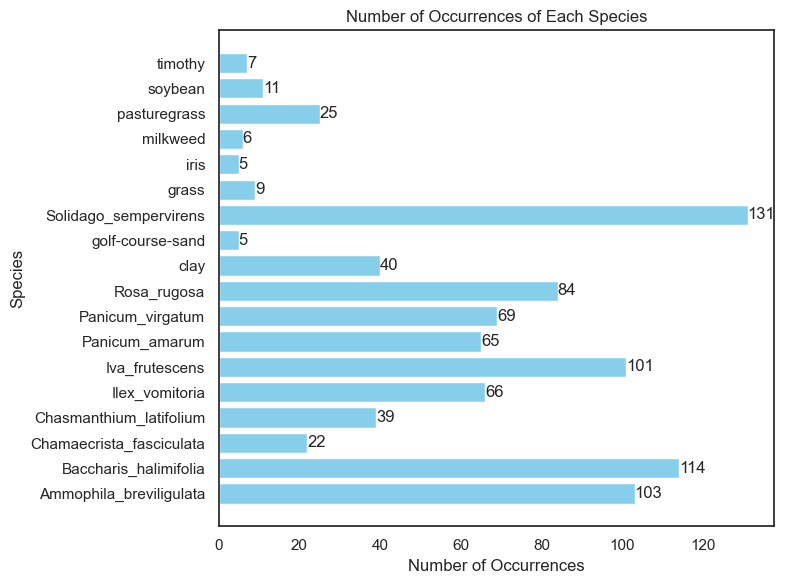

In [9]:
# Count the occurrences of each unique value
name_counts = Counter(name)
# Extract the labels and values
labels, values = zip(*name_counts.items())
# Create the horizontal bar plot
plt.figure(figsize=(8, 6))
bars = plt.barh(labels, values, color='skyblue')
# Add text labels on the bars
for bar, value in zip(bars, values):
    plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, str(value), ha='left', va='center')
# Set the labels and title
plt.ylabel('Species')
plt.xlabel('Number of Occurrences')
plt.title('Number of Occurrences of Each Species')
plt.tight_layout()
plt.show()

In [12]:
len(wl)

2151

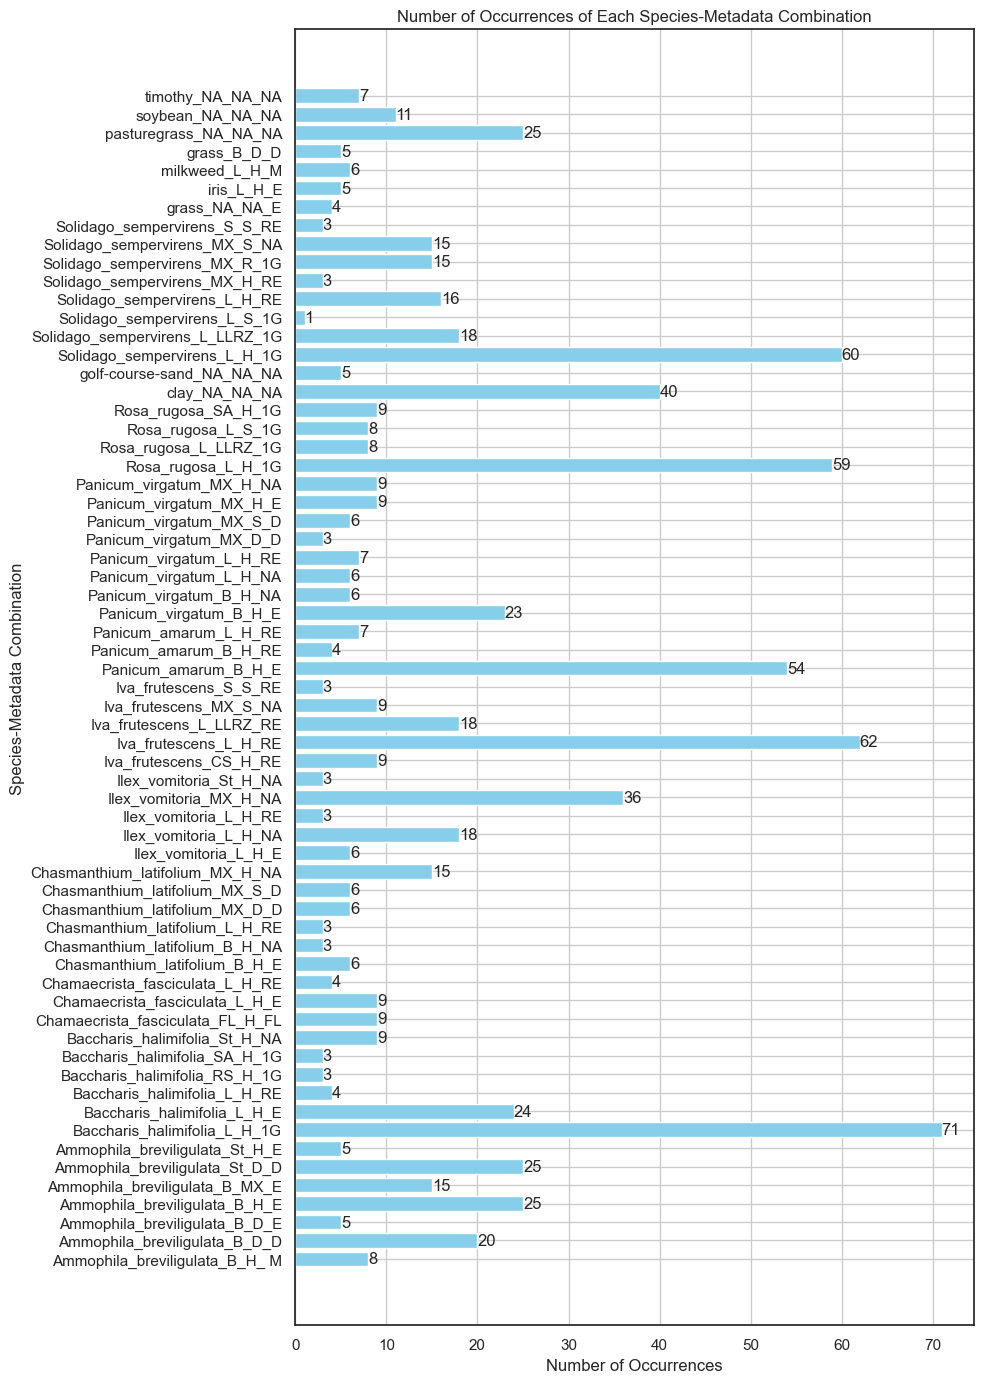

In [6]:
# Count the occurrences of each unique value
name_full_category_counts = Counter(name_full_category)
# Extract the labels and values
labels, values = zip(*name_full_category_counts.items())
# Create the horizontal bar plot
plt.figure(figsize=(10, 14))
bars = plt.barh(labels, values, color='skyblue')
plt.grid(True)
# Add text labels on the bars
for bar, value in zip(bars, values):
    plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, str(value), ha='left', va='center')
# Set the labels and title
plt.ylabel('Species-Metadata Combination')
plt.xlabel('Number of Occurrences')
plt.title('Number of Occurrences of Each Species-Metadata Combination')
plt.tight_layout()
plt.show()

# Plot some spectra for the library

In [7]:
# Set the fontsize and create a function to colot plots be a specific metadata category
def set_color(x, colormap_name = 'tab20'):
    # This function returns a dictionary of colors based on the input numpy x of metadata values
    # The default colormap is tab10 (tableau 10), but any named colormap can be used
    categories = np.unique(x)
    if colormap_name == 'custom':
        color_list = ['r','g','b','c','m','y','maroon','orange',
              'darkgreen','peru','navy','teal',
              'indigo','crimson','pink','slategrey',
              'darkgoldenrod','purple']
        clr = {}
        for i,category in enumerate(categories):
            clr[category] = color_list[i]
    else:
        clr = {}
        cmap = matplotlib.cm.get_cmap(colormap_name)
        for i,category in enumerate(categories):
            clr[category] = cmap(i/len(categories))
    return clr 
    

In [13]:
# plot some random spectra
plt.figure(figsize=(12,6))
for idx in rnd_idx:
    plt.plot(wl, spectra[idx], label=name[idx], lw=1, c=clr[name[idx]])
plt.grid(True)
plt.xlabel('Wavelength')
plt.ylabel('Refletance')
plt.title('Fifteen Randomly Selected Spectra')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left');

NameError: name 'rnd_idx' is not defined

<Figure size 1200x600 with 0 Axes>

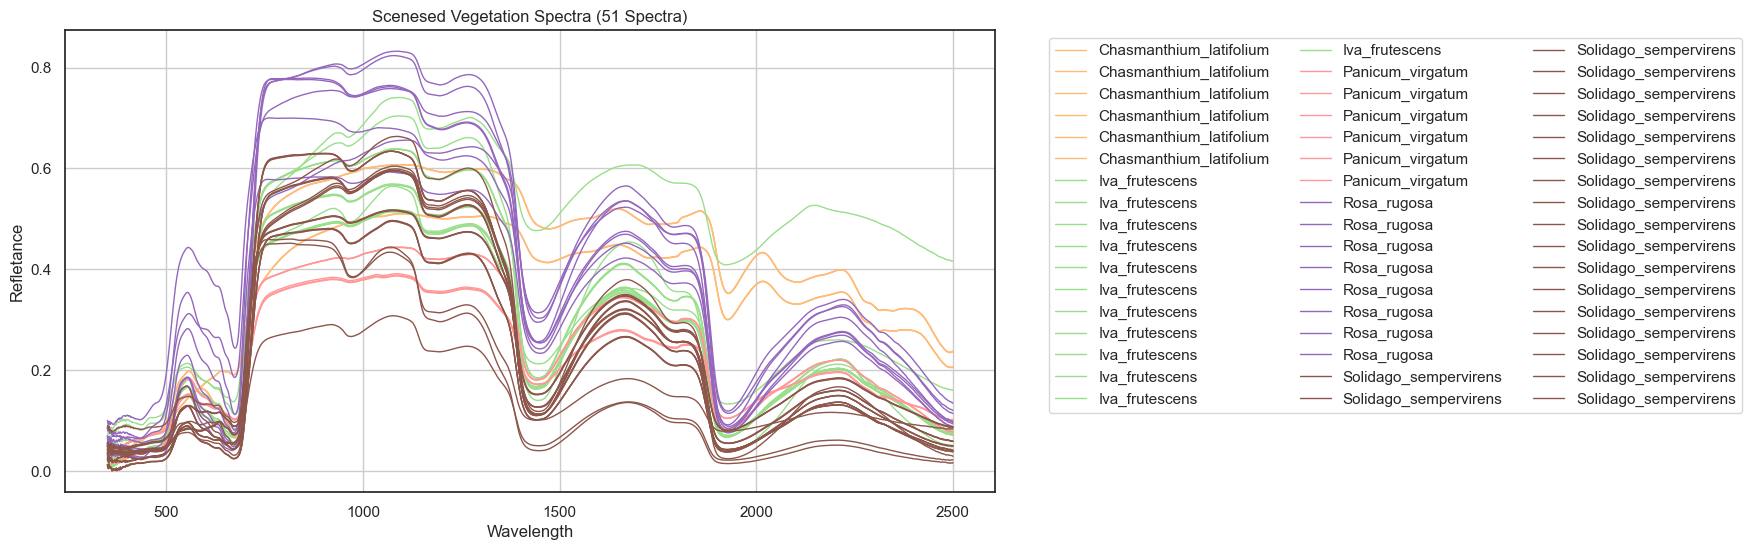

In [14]:
# plot spectra satisfying some condition - note that we add 3 columns to the legend because there are more labels to show
plt.figure(figsize=(12,6))
plt.grid(True)
selected_indices = np.where(health=='S')[0]
clr = set_color(name)
for idx in selected_indices:
    plt.plot(wl, spectra[idx], label=name[idx], lw=1, c=clr[name[idx]])
plt.xlabel('Wavelength')
plt.ylabel('Refletance')
plt.title(f'Scenesed Vegetation Spectra ({len(selected_indices)} Spectra)')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left', ncols=3);

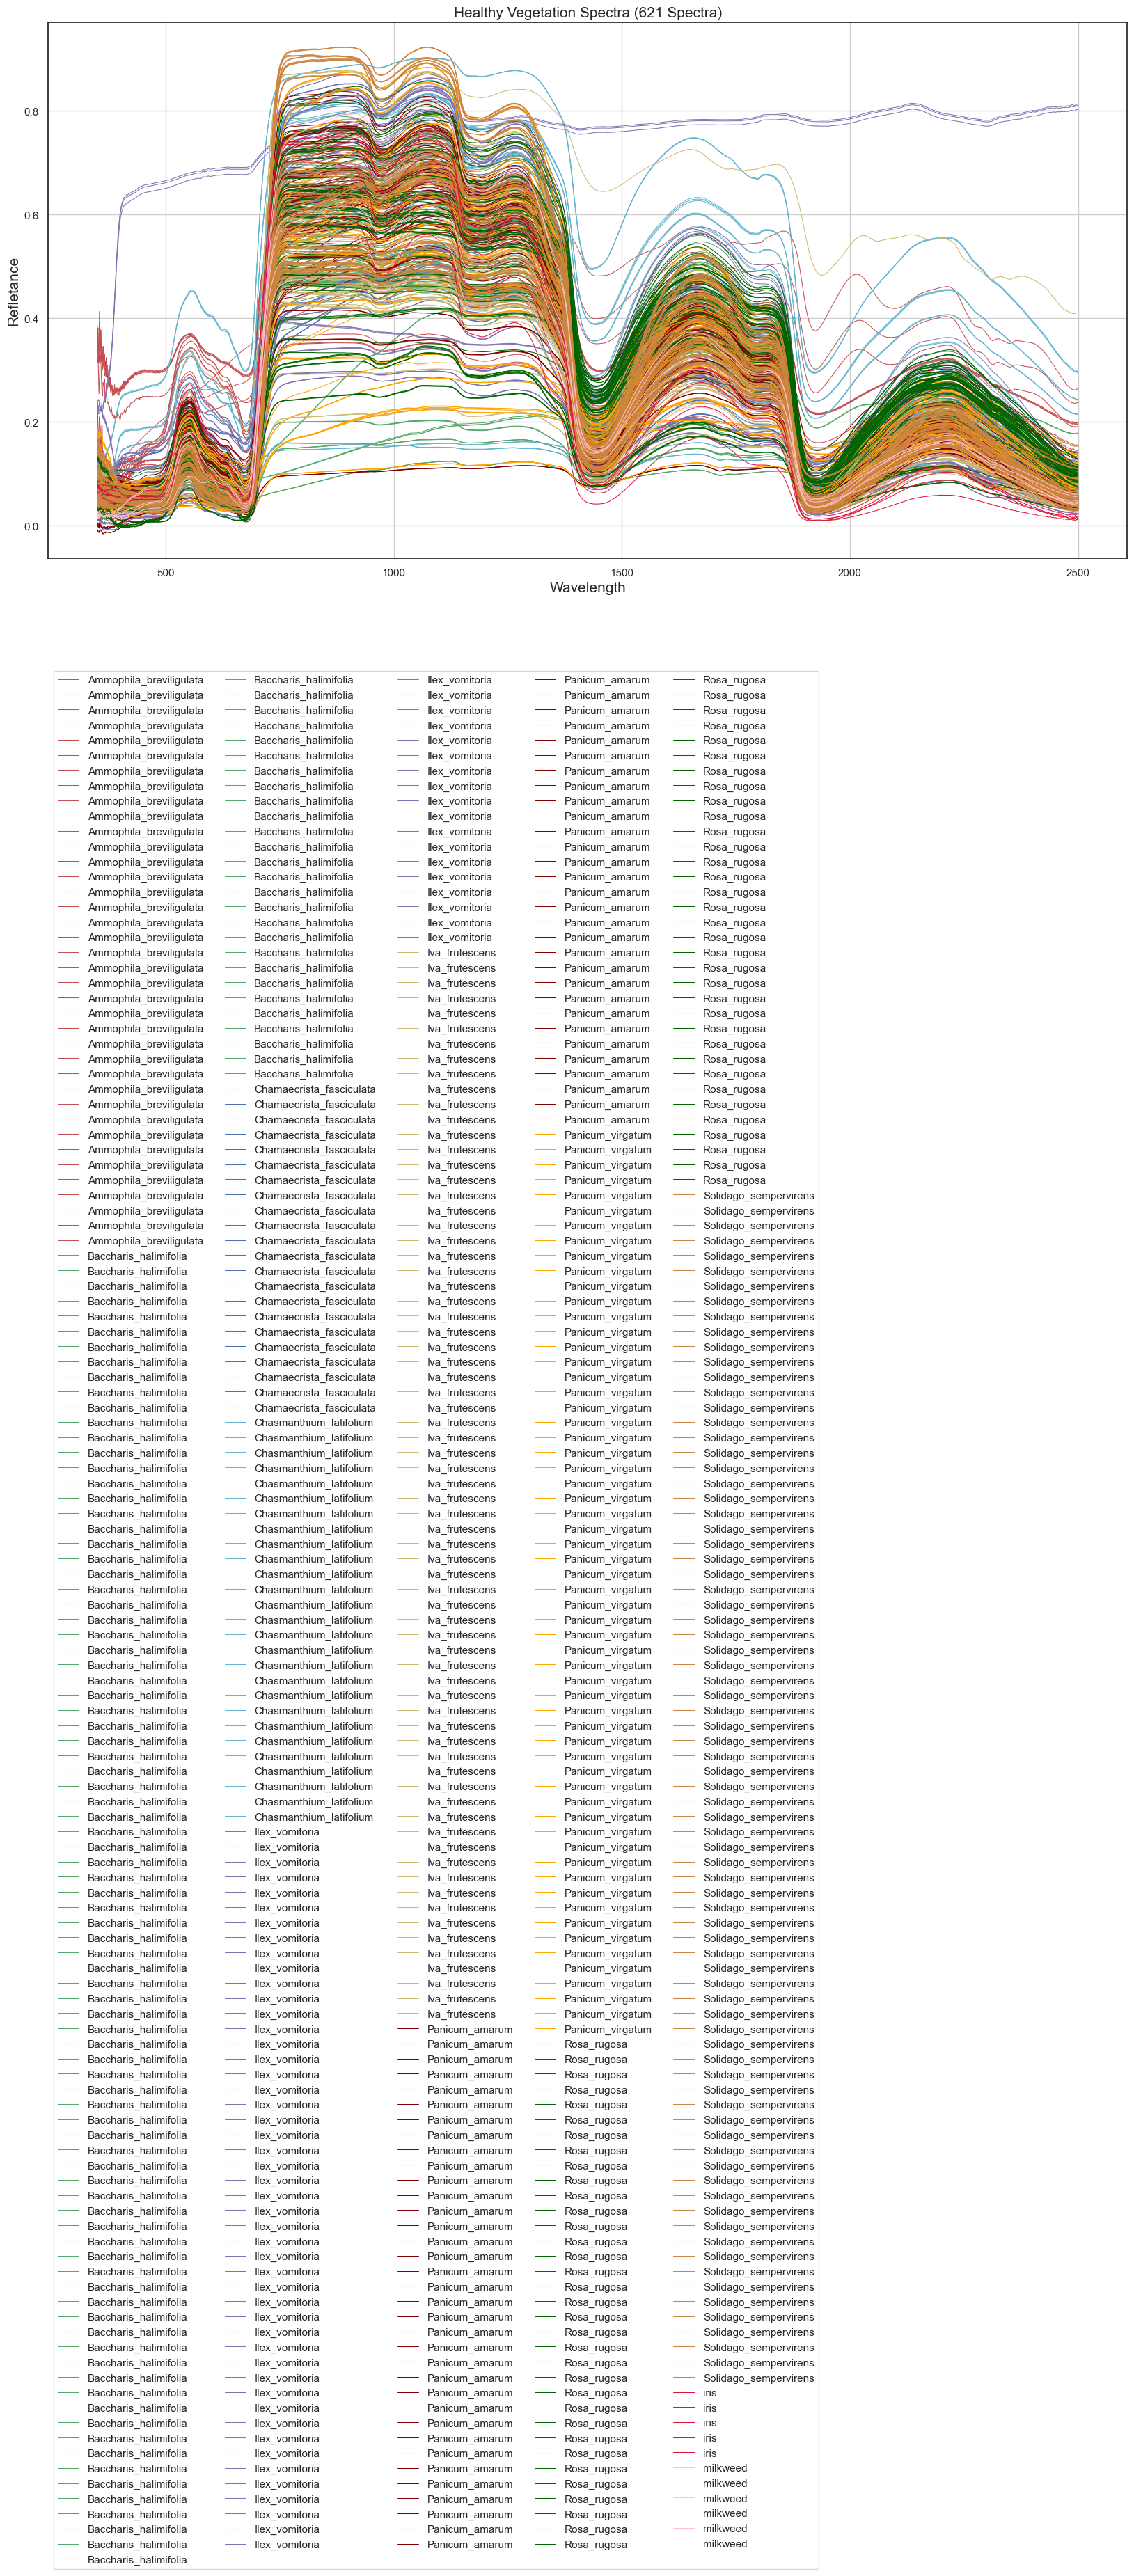

In [ ]:
# plot spectra for healthy vegetation
plt.figure(figsize=(20,10))
plt.grid(True)
selected_indices = np.where(health=='H')[0]
for idx in selected_indices:
    plt.plot(wl, spectra[idx], label=name[idx], lw=0.75, c=clr[name[idx]])
plt.xlabel('Wavelength', fontsize=fontsize)
plt.ylabel('Refletance', fontsize=fontsize)
plt.title(f'Healthy Vegetation Spectra ({len(selected_indices)} Spectra)')
plt.legend(bbox_to_anchor=(0.0, -0.2), loc='upper left', ncols=5);